In [1]:
# Cell 1: Load and convert Fashion MNIST dataset to a DataFrame
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
import torch.nn.functional as F

### Pretend we are NOT doing this - imagine it being you donwloading data from the internet

In [2]:
# Download and load the Fashion MNIST dataset
transform = transforms.ToTensor()  # Transform the data into tensors
full_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)

In [3]:
# Convert the dataset to a DataFrame
# Each image is a 28x28 array, flatten it into a single row
data_list = []
for image, label in full_dataset:
    flat_image = image.view(-1).numpy()  # Flatten the 28x28 image into a 1D array
    data_list.append([*flat_image, label])

# Create a DataFrame
columns = [f"pixel_{i}" for i in range(28 * 28)] + ["label"]
full_df = pd.DataFrame(data_list, columns=columns)

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42)

# Display the first few rows of each DataFrame
print("Train DataFrame:")
print(train_df.head())
print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame:
       pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
48572      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
38696      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
13611      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
35213      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
31766      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel_7   pixel_8   pixel_9  ...  pixel_775  pixel_776  pixel_777  \
48572  0.000000  0.000000  0.000000  ...   0.000000   0.000000   0.000000   
38696  0.000000  0.000000  0.000000  ...   0.003922   0.000000   0.000000   
13611  0.000000  0.000000  0.000000  ...   0.000000   0.000000   0.000000   
35213  0.000000  0.000000  0.011765  ...   0.501961   0.576471   0.658824   
31766  0.011765  0.223529  0.368627  ...   0.000000   0.000000   0.000000   

       pixel_778  pixel_779  pixel_780  pixel_781  pixel_782  pixel_783  label  
48572 

### Let's start here by examining the data

In [4]:
train_df = pd.DataFrame(data_list, columns=columns)

# Display the first few rows of the DataFrame
train_df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
train_df.shape, test_df.shape

((60000, 785), (12000, 785))

In [6]:
train_df.max()

pixel_0      0.062745
pixel_1      0.141176
pixel_2      0.466667
pixel_3      0.643137
pixel_4      0.878431
               ...   
pixel_780    1.000000
pixel_781    1.000000
pixel_782    1.000000
pixel_783    0.666667
label        9.000000
Length: 785, dtype: float64

## Helper to visualize a row of data - nice for images

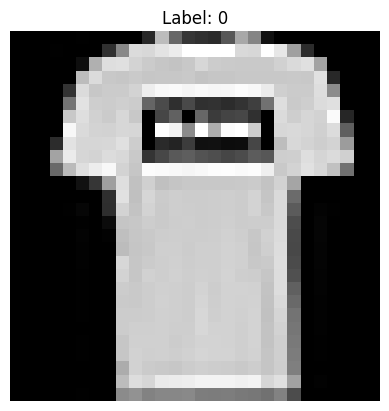

In [7]:
# Cell 8: Function to display a greyscale image from a row
def show_image_from_row(row, label):
    # Reshape the row back to a 28x28 image
    image = np.array(row).reshape(28, 28)
    
    # Plot the image
    plt.imshow(image, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

# Example: Display an image from the DataFrame
example_row = train_df.iloc[1, :-1]  # First row (pixels only)
example_label = train_df.iloc[1, -1]  # Corresponding label
show_image_from_row(example_row, example_label)


In [8]:
# Labels

# Each training and test example is assigned to one of the following labels:

# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

## Example Dataloader

In [9]:

# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        """
        Initialize the dataset by passing a DataFrame.
        Args:
            dataframe (pd.DataFrame): DataFrame with pixel data and labels.
        """
        self.data = dataframe.iloc[:, :-1].values  # Features (all columns except the last)
        self.labels = dataframe.iloc[:, -1].values  # Labels (last column)

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            (torch.Tensor, torch.Tensor): Tuple of features and label.
        """
        # Convert the features and label to tensors
        features = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, label



In [10]:
# Function to split the DataFrame and create DataLoaders
def create_train_test_dataloaders(dataframe, test_size=0.2, batch_size=64, shuffle=True):
    """
    Split the DataFrame into train and test sets and create DataLoaders.
    Args:
        dataframe (pd.DataFrame): DataFrame containing the data.
        test_size (float): Proportion of the data to be used as test data.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle the data.
    Returns:
        tuple: (train_loader, test_loader)
    """
    # Split the data into train and test sets
    train_df, test_df = train_test_split(dataframe, test_size=test_size, random_state=42)
    
    # Create train and test datasets
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    
    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [11]:
# ## command + /

# # Example usage: Creating train and test DataLoaders
# train_loader, test_loader = create_train_test_dataloaders(train_df, test_size=0.2, batch_size=32)

# # Example: Check the first batch from the train DataLoader
# for batch_idx, (features, labels) in enumerate(train_loader):
#     print(f"Train Batch {batch_idx + 1}")
#     print("Features shape:", features.shape)
#     print("Labels shape:", labels.shape)
#     break  # Display only the first batch

# # Example: Check the first batch from the test DataLoader
# for batch_idx, (features, labels) in enumerate(test_loader):
#     print(f"Test Batch {batch_idx + 1}")
#     print("Features shape:", features.shape)
#     print("Labels shape:", labels.shape)
#     break  # Display only the first batch

## Manually Build dataloaders

In [12]:
# # Cell 2: Create a DataLoader


# # Convert the DataFrame back to PyTorch tensors
# X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32)  # All pixels
# y_train = torch.tensor(train_df["label"].values, dtype=torch.long)  # Labels
# # Convert the DataFrame back to PyTorch tensors
# X_test = torch.tensor(test_df.iloc[:, :-1].values, dtype=torch.float32)  # All pixels
# y_test = torch.tensor(test_df["label"].values, dtype=torch.long)  # Labels

# # Create a TensorDataset
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# # Create a DataLoader for batching and shuffling
# batch_size = 32  # Number of samples per batch
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [13]:

# Reshape images to 2D format [batch_size, 1, 28, 28]
X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0  # Normalize
X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0  # Normalize

y_train = torch.tensor(train_df["label"].values, dtype=torch.long)
#y_train = torch.tensor(train_df["label"].values, dtype=torch.long).view(-1, 1)  # Adds an extra dimension

X_test = torch.tensor(test_df.iloc[:, :-1].values, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0  # Normalize
y_test = torch.tensor(test_df["label"].values, dtype=torch.long)
#y_train = torch.tensor(train_df["label"].values, dtype=torch.long).view(-1, 1)  # Adds an extra dimension

# Create PyTorch Datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders for batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print shape of a single batch to verify correctness
sample_images, sample_labels = next(iter(train_loader))
print(f"Image batch shape: {sample_images.shape}")  # Expected: [64, 1, 28, 28]
print(f"Label batch shape: {sample_labels.shape}")  # Expected: [64]


Image batch shape: torch.Size([32, 1, 28, 28])
Label batch shape: torch.Size([32])


In [14]:
# Example: Check the first batch
for batch in train_loader:
    images, labels = batch
    print(f"Batch size: {images.shape}, Labels: {labels.shape}")
    break
# Example: Check the first batch
for batch in test_loader:
    images, labels = batch
    print(f"Batch size: {images.shape}, Labels: {labels.shape}")
    break

Batch size: torch.Size([32, 1, 28, 28]), Labels: torch.Size([32])
Batch size: torch.Size([32, 1, 28, 28]), Labels: torch.Size([32])


In [15]:
# # Cell 3: Define the neural network

# # Define a feedforward network for classification
# class SimpleNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         x = self.fc1(x)  # First layer
#         x = self.relu(x)
#         x = self.fc2(x)  # Output layer
#         return x



In [16]:

class CustomCNN(nn.Module):
    def __init__(self, num_classes=10, kernel_size=3, stride=1, padding=1, dropout_prob=0.5):
        """
        Custom CNN with LeakyReLU to prevent dead neurons.
        
        Args:
            num_classes (int): Number of output classes.
            kernel_size (int): Size of the convolutional kernel.
            stride (int): Stride length for convolution.
            padding (int): Padding for convolution.
            dropout_prob (float): Dropout probability.
        """
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding)
        
        # Pooling and Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size by half
        self.dropout = nn.Dropout(dropout_prob)  # Regularization
        
        # Activation function (LeakyReLU instead of ReLU)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # ✅ Prevents dead neurons

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 7 * 7, 100)  # Bottleneck layer (Embedding Space)
        self.fc2 = nn.Linear(100, num_classes)  # Final classification layer

    def forward(self, x):
        """
        Forward pass with LeakyReLU.
        """
        x = self.leaky_relu(self.conv1(x))
        x = self.pool(x)

        x = self.leaky_relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
    
        x = self.leaky_relu(self.fc1(x))  # Bottleneck layer
        x = self.dropout(x)

        out = self.fc2(x)  # Final classification layer
    
        return out  # Return only logits


In [17]:
# # Initialize the model
# input_size = 784  # 784 input features (flattened image)
# hidden_size = 256  # Number of neurons in the hidden layer
# num_classes = 10  # 10 classes for Fashion MNIST


In [18]:
# model = SimpleNN(input_size, hidden_size, num_classes)

# # Print the model architecture
# print(model)

In [19]:
# constructor: num_classes=10, kernel_size=3, stride=1, padding=1, dropout_prob=0.5
model = CustomCNN(num_classes=10, kernel_size=3, stride=1, padding=1, dropout_prob=0.5)

# Print the model architecture
print(model)

CustomCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [20]:
# Cell 4: Define hyperparameters
learning_rate = 0.0005
num_epochs = 10
#batch_size = 64

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


### for later!

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model.to(device)
print(f"Using {device} device")


Using mps device


## Model Training

In [22]:
# Training the model
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for rows, labels in train_loader:
        # Forward pass
        outputs = model(rows.to(device))
        loss = criterion(outputs, labels.to(device))

        # Backward pass
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        #for name, param in model.named_parameters():
         #   if param.grad is not None:
          #      print(f"{name}: Mean Grad: {param.grad.mean():.6f}")
        optimizer.step()  # Update weights
        #for name, param in model.named_parameters():
         #   if param.grad is not None:
          #      print(f"{name}: Mean Grad: {param.grad.mean():.6f}")

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 2.1210
Epoch [2/10], Loss: 0.7783
Epoch [3/10], Loss: 0.6726
Epoch [4/10], Loss: 0.6257
Epoch [5/10], Loss: 0.5946
Epoch [6/10], Loss: 0.5664
Epoch [7/10], Loss: 0.5456
Epoch [8/10], Loss: 0.5214
Epoch [9/10], Loss: 0.5023
Epoch [10/10], Loss: 0.4880


## Saving and loading a model

In [23]:
# Save the model after training
# torch.save(model.state_dict(), "fashion_mnist_model.pth")
# print("Model saved as 'fashion_mnist_model.pth'")


In [24]:
torch.save(model.state_dict(), "fashion_mnist_cnn.pth")
print("Model saved as 'fashion_mnist_cnn.pth'")

Model saved as 'fashion_mnist_cnn.pth'


In [25]:
# # Load the saved model for inference
# model = SimpleNN(input_size, hidden_size, num_classes)  # Reinitialize the model structure
# model.load_state_dict(torch.load("fashion_mnist_model.pth"))
# model.eval()  # Set the model to evaluation mode
# print("Model loaded and ready for inference.")


In [26]:
# Load the saved model for inference
model = CustomCNN(num_classes=10, kernel_size=3, stride=1, padding=1, dropout_prob=0.0) # Reinitialize the model structure
model.load_state_dict(torch.load("fashion_mnist_cnn.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded and ready for inference.")


Model loaded and ready for inference.


In [27]:
# Cell 6: Inference loop
# Running inference
model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for efficiency
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 84.34%


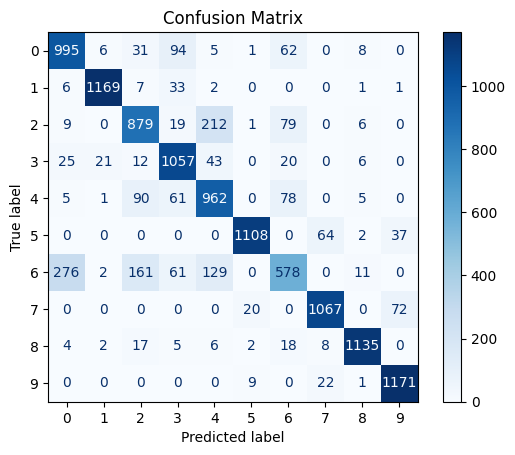

In [28]:

# Generate predictions for the entire dataset
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Compute and plot the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Inspect a row of data

In [29]:
# Helper function to run inference on a single row of data
def run_inference_on_row(row, label, model):
    # Convert the row into a tensor
    row_tensor = torch.tensor(row.values, dtype=torch.float32).view(-1, 1, 28, 28)  # Add batch dimension
    #torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0

    # Perform inference
    with torch.no_grad():
        logits = model(row_tensor)  # Raw logits
        probabilities = torch.softmax(logits, dim=1)  # Apply softmax to convert logits to probabilities

    # Get predicted label
    predicted_label = torch.argmax(probabilities).item()

    # Print details
    print("Logits:", logits.numpy())
    print("Softmax Probabilities:", probabilities.numpy())
    print("Correct Label:", label)
    print("Predicted Label:", predicted_label)

    return predicted_label

# Example: Run inference on a single row
example_row = test_df.iloc[10, :-1]  # 10th row (pixels only)
example_label = test_df.iloc[10, -1]  # Corresponding label
run_inference_on_row(example_row, example_label, model)

Logits: [[  265.5123    -123.63881      8.010638    64.29213    191.65605
  -1852.9307      86.454926 -1589.3906    -384.50357  -1001.9626  ]]
Softmax Probabilities: [[1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 8.40697e-33 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]]
Correct Label: 3
Predicted Label: 0


0

In [30]:
### Display examples of correct and incorrect predictions

In [31]:

def display_examples(data_df, model, correct=True, num_examples=3):
    count = 0
    plt.figure(figsize=(10, 5))

    for idx, row in data_df.iterrows():
        if count >= num_examples:
            break

        # Extract image and label
        image_row = row[:-1]
        true_label = row[-1]

        # Run inference
        predicted_label = run_inference_on_row(image_row, true_label, model)

        # Check if prediction is correct
        if (predicted_label == true_label and correct) or (predicted_label != true_label and not correct):
            # Plot the image
            plt.subplot(1, num_examples, count + 1)
            image = image_row.values.reshape(28, 28)  # Reshape to 28x28
            plt.imshow(image, cmap="gray")
            plt.title(f"True: {true_label}, Pred: {predicted_label}")
            plt.axis("off")
            count += 1






Examples of Correct Predictions:
Logits: [[-2.2448215e+03 -4.1073574e+03 -2.6588936e+03 -1.2827191e+03
  -2.1869131e+03  1.2326274e+03 -2.2238921e+03  9.9855829e+02
   1.1818310e+00  2.1667957e+03]]
Softmax Probabilities: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Correct Label: 9.0
Predicted Label: 9
Logits: [[ 1133.7205  -1260.4954   -307.2243   -279.54544 -1348.6276  -2206.214
    809.651   -3314.283      97.00193 -2949.575  ]]
Softmax Probabilities: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Correct Label: 0.0
Predicted Label: 0
Logits: [[  -11.55262    671.57025    -25.867374    44.627487   403.30914
  -1546.289     -232.1152   -1338.7604    -898.2037   -1373.4668  ]]
Softmax Probabilities: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Correct Label: 0.0
Predicted Label: 1
Logits: [[  290.36072    394.65903     31.533707   284.39847    -72.177895
  -1902.6302     255.7785   -2169.8606    -621.3039   -1854.4895  ]]
Softmax Probabilities: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Correct Label: 3.0
Predicted Label: 1
Lo

/var/folders/83/s01xl68d2q3gdtkbr5ptq6nc0000gn/T/ipykernel_35107/3303586380.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[-1]


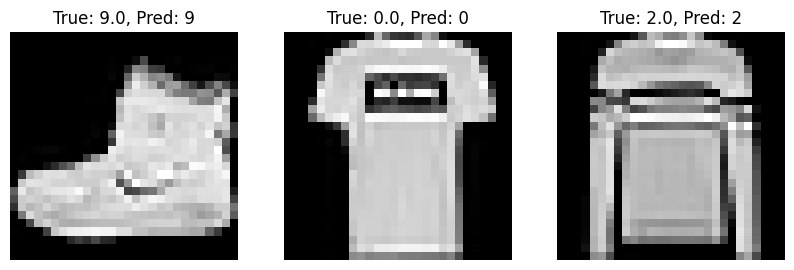

In [32]:
# Example: Show 3 correct predictions
print("Examples of Correct Predictions:")
display_examples(train_df, model, correct=True, num_examples=3)
plt.show()

/var/folders/83/s01xl68d2q3gdtkbr5ptq6nc0000gn/T/ipykernel_35107/3303586380.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[-1]


Examples of Incorrect Predictions:
Logits: [[-2.2448215e+03 -4.1073574e+03 -2.6588936e+03 -1.2827191e+03
  -2.1869131e+03  1.2326274e+03 -2.2238921e+03  9.9855829e+02
   1.1818310e+00  2.1667957e+03]]
Softmax Probabilities: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Correct Label: 9.0
Predicted Label: 9
Logits: [[ 1133.7205  -1260.4954   -307.2243   -279.54544 -1348.6276  -2206.214
    809.651   -3314.283      97.00193 -2949.575  ]]
Softmax Probabilities: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Correct Label: 0.0
Predicted Label: 0
Logits: [[  -11.55262    671.57025    -25.867374    44.627487   403.30914
  -1546.289     -232.1152   -1338.7604    -898.2037   -1373.4668  ]]
Softmax Probabilities: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Correct Label: 0.0
Predicted Label: 1
Logits: [[  290.36072    394.65903     31.533707   284.39847    -72.177895
  -1902.6302     255.7785   -2169.8606    -621.3039   -1854.4895  ]]
Softmax Probabilities: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Correct Label: 3.0
Predicted Label: 1


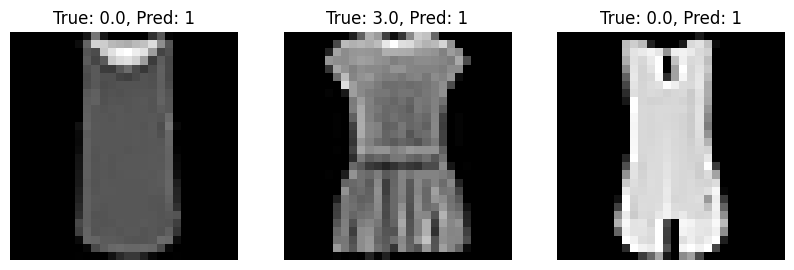

In [33]:
# Example: Show 3 incorrect predictions
print("Examples of Incorrect Predictions:")
display_examples(train_df, model, correct=False, num_examples=3)
plt.show()

In [45]:
import torch
import numpy as np
import math
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

def create_tensorboard_visualization(model_path, dataloader, device, log_dir="runs/fashion_mnist"):
    """
    Reads the trained model, creates a TensorBoard visualization of:
    - The embedding space with labels and images
    - Sample images

    Args:
        model_path (str): Path to the trained model file.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to load the model and data on.
        log_dir (str): Directory where TensorBoard logs will be saved.

    Returns:
        None
    """
    # Ensure `device` is a `torch.device` object
    if isinstance(device, str):
        device = torch.device(device)

    # Load the trained model
    model = CustomCNN(num_classes=10, kernel_size=3, stride=1, padding=1, dropout_prob=0.0)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Set model to evaluation mode
    
    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir)
    
    # Store features and labels for embedding visualization
    features_list = []
    labels_list = []
    images_list = []

    # Collect data from the DataLoader
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)  # Move data to device
            
            # Forward pass through model to extract embeddings
            x = model.leaky_relu(model.conv1(images))
            x = model.pool(x)
            x = model.leaky_relu(model.conv2(x))
            x = model.pool(x)
            x = x.view(x.size(0), -1)  # Flatten before FC layers
            embeddings = model.leaky_relu(model.fc1(x))  # ✅ Extract embeddings from fc1
            
            features_list.append(embeddings.cpu())  # Store embeddings
            labels_list.append(labels.cpu())  # Store labels
            images_list.append(images.cpu())  # Store images

            #break  # Only process first batch for visualization

    # Concatenate all features and labels
    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0).numpy()  # ✅ Convert labels to NumPy
    images = torch.cat(images_list, dim=0)

    # Fix `label_img` shape (Move channel from (N, 1, 28, 28) → (N, 28, 28, 3))
    label_img = images[:features.shape[0]].view(-1, 1, 28, 28).cpu().numpy()  # ✅ Ensure correct shape
    label_img = np.transpose(label_img, (0, 2, 3, 1))  # ✅ Fix: Move channel to last dim (N, 28, 28, 1)
    label_img = np.tile(label_img, (1, 1, 1, 3))  # ✅ Convert grayscale (1 channel) to RGB (3 channels)

    # 🚀 Fix: Ensure image values are in [0, 255] range
    label_img = np.clip(label_img * 255.0, 0, 255).astype(np.uint8)

    # 🚨 Debugging prints
    print(f"Features Shape: {features.shape}")  # Expected: (N, D)
    print(f"Labels Shape: {labels.shape}")  # Expected: (N,)
    print(f"Label Image Shape: {label_img.shape}")  # Expected: (N, 28, 28, 3)")
    print(f"Label Image dtype: {label_img.dtype}")  # Should be uint8
    print(f"Fixed Label Image min/max: {label_img.min()}, {label_img.max()}")  # Should be 0, 255

    # 🚀 Fix: Ensure feature and label_img shapes match
    if features.shape[0] != label_img.shape[0]:
        min_size = min(features.shape[0], label_img.shape[0])
        features = features[:min_size]
        label_img = label_img[:min_size]
        labels = labels[:min_size]

    # 🚨 TESTING: Directly call `make_sprite()` on a single image
    from torch.utils.tensorboard._embedding import make_sprite
    try:
        test_sprite = np.random.randint(0, 255, (1, 28, 28, 3), dtype=np.uint8)  # Generate test image
        make_sprite(test_sprite, "/tmp/test_sprite.png")  # ✅ Test Sprite
        print("✅ make_sprite() worked correctly!")
    except Exception as e:
        print(f"❌ make_sprite() error: {e}")

    # 🚀 TEMPORARILY REMOVE `label_img` to see if `add_embedding()` works
    try:
        writer.add_embedding(
            features,
            metadata=labels.tolist(),  # ✅ Convert to list
            # label_img=label_img,  # ❌ Temporarily remove this to check if TensorBoard works without it
            global_step=0
        )
        print("✅ add_embedding() worked successfully!")
    except Exception as e:
        print(f"❌ add_embedding() error: {e}")

    # Optionally visualize some sample images in TensorBoard
    grid = make_grid(images[:64].view(-1, 1, 28, 28), nrow=8, normalize=True)
    writer.add_image("FashionMNIST Samples", grid, global_step=0)
    
    # Close the writer
    writer.close()
    print(f"TensorBoard logs saved to: {log_dir}")


In [46]:
device = torch.device("cpu")  # ✅ Ensure `device` is correctly formatted

create_tensorboard_visualization("fashion_mnist_cnn.pth", test_loader, device)


Features Shape: torch.Size([12000, 100])
Labels Shape: (12000,)
Label Image Shape: (12000, 28, 28, 3)
Label Image dtype: uint8
Fixed Label Image min/max: 0, 1
❌ make_sprite() error: 'int' object is not callable
✅ add_embedding() worked successfully!
TensorBoard logs saved to: runs/fashion_mnist
